In [1]:

from mri_loader import MRI

import pandas as pd
import numpy as np



In [25]:
subject_id = 11

run_ids = list(range(1, 5))

(subject_id, run_ids)

(11, [1, 2, 3, 4])

In [26]:
dataset = [MRI(subject_id, run_id) for run_id in run_ids]

[mri.load() for mri in dataset]

dataset

In [27]:
dataset[0].labels["morph level"].values

array([45, 45, 75, 75, 55, 55, 55, 55, 55, 55,  5,  5, 75, 75, 35, 35, 75,
       75,  5,  5,  5,  5, 45, 45, 65, 65, 95, 95, 85, 85, 45, 45, 45, 45,
       35, 35, 35, 35, 15, 15, 15, 15, 55, 55, 15, 15, 15, 15, 95, 95, 95,
       95, 55, 55, 15, 15, 95, 95, 65, 65, 55, 55, 55, 55,  5,  5, 45, 45,
       25, 25, 65, 65, 75, 75, 15, 15, 25, 25, 25, 25, 85, 85, 85, 85, 75,
       75, 15, 15, 25, 25, 45, 45, 75, 75, 85, 85, 25, 25, 25, 25, 95, 95,
       85, 85, 65, 65, 65, 65, 95, 95,  5,  5, 85, 85, 75, 75,  5,  5,  5,
        5, 65, 65, 85, 85, 95, 95, 75, 75, 35, 35, 25, 25,  5,  5, 95, 95,
       45, 45, 45, 45, 45, 45, 55, 55, 55, 55,  5,  5, 85, 85, 55, 55, 15,
       15, 35, 35, 35, 35, 35, 35, 75, 75, 75, 75, 15, 15, 45, 45, 95, 95,
       65, 65, 25, 25, 35, 35, 55, 55, 45, 45, 35, 35, 85, 85, 85, 85, 45,
       45, 95, 95, 25, 25, 25, 25, 85, 85, 45, 45, 45, 45, 45, 45, 45, 45])

In [28]:
images = []
times = []
labels = []

last_timestamp = 0

for run in dataset:
    images.append(run.data)
    times.append(run.mri_timestamps + last_timestamp)
    labels.append(run.labels["morph level"].values)

    last_timestamp += run.mri_timestamps[-1]



In [29]:
from nilearn.image import concat_imgs

images = concat_imgs(images)

In [30]:
times = np.concatenate(times)
labels = np.concatenate(labels)

In [31]:
times.shape

(816,)

In [32]:
labels.shape

(816,)

In [33]:
images.shape

(65, 77, 55, 816)

In [34]:
events = pd.DataFrame(
    {'onset': times,
     'trial_type': [str(v) for v in labels],
     'duration': 2.5}
)


In [35]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix


<Axes: label='conditions', ylabel='scan number'>

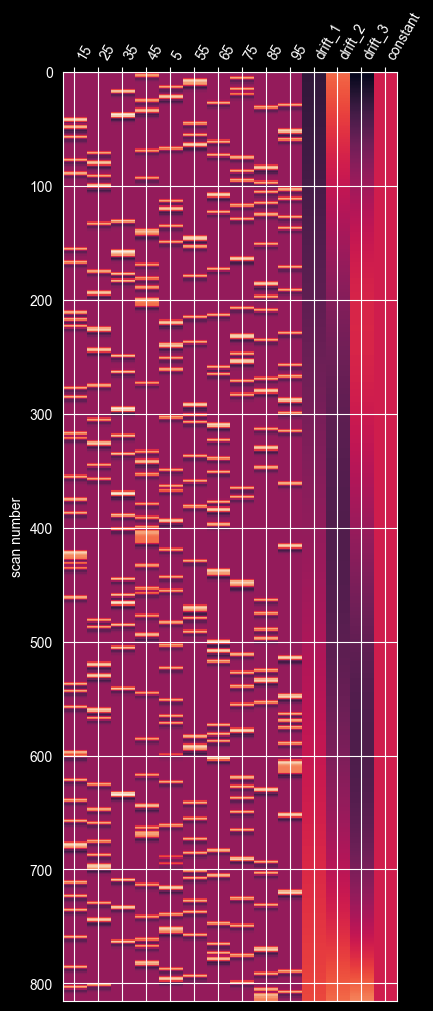

In [36]:


design_matrices = make_first_level_design_matrix(times, events,
                                                 drift_model='polynomial', drift_order=3)
plot_design_matrix(design_matrices)


In [39]:
from nilearn.glm.first_level import FirstLevelModel


In [40]:

repetition_time = dataset[0]._t_r
fmri_glm = FirstLevelModel(t_r=repetition_time,
          drift_model='polynomial',
          drift_order=3,
          signal_scaling=False,
          mask_img=dataset[0].brain_mask,
          standardize=False,
          smoothing_fwhm=6,
          n_jobs=-1)



In [41]:

fmri_glm = fmri_glm.fit(images, events)


MemoryError: Unable to allocate 857. MiB for an array with shape (65, 77, 55, 816) and data type float32